# 새로운 패션 만들기

## 1. 데이터 준비

In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.6.0


우리는 분류모델을 만드는 게 아니어서 라벨데이터는 사용하지 않는다.

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_x, _), (test_x, _) = fashion_mnist.load_data()

In [3]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


-1과 1사이로 정규화 시켜준다.

In [4]:
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [5]:
train_x.shape

(60000, 28, 28)

딥러닝에서 이미지를 다루기 위해서는 채널 수에 대한 차원이 필요하다. 지금 사용하는 이미지는 흑백이니까 shape의 마지막에 1을 추가한다.

In [6]:
train_x = train_x.reshape(train_x.shape[0], 28, 28, 1).astype('float32')
train_x.shape

(60000, 28, 28, 1)

첫 번째 데이터 확인

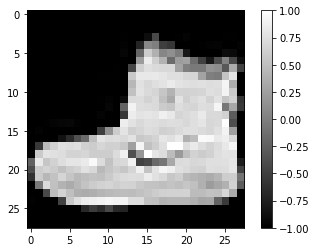

In [7]:
plt.imshow(train_x[0].reshape(28, 28), cmap='gray')
plt.colorbar()
plt.show()

이미지 10장 확인

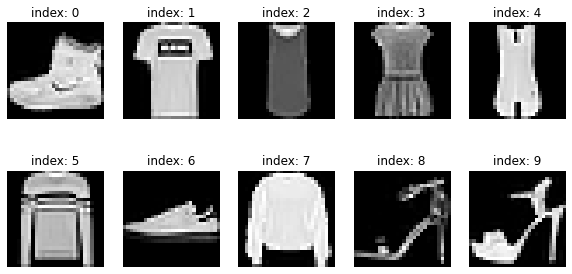

In [8]:
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_x[i].reshape(28, 28), cmap='gray')
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

랜덤으로 25개 이미지 꺼내보기

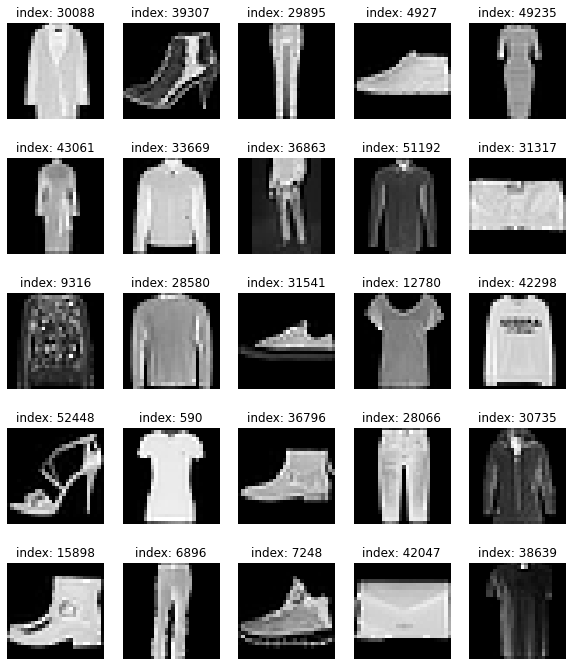

In [22]:
plt.figure(figsize=(10, 12))

for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(train_x[np.random.randint(60000)].reshape(28, 28), cmap='gray')
    plt.title(f'index: {np.random.randint(60000)}')
    plt.axis('off')
plt.show()

버퍼 사이즈와 배치사이즈를 정한다.
미니 배치 학습을 사용한다.

In [25]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## 2. 모델 준비

DCGAN모델을 사용한다.

### 2-1 생성자 구현하기

`Conv2DTranspose`레이어가 가장 중요하다. 일반적인 Conv2D와 반대로 이미지 사이즈를 넓혀주는 층이다. 3번의 층을 거치면서 최종 사이즈 28,28,1로 만든다. 

`BatchNormalization`레이어를 사용해서 신경망의 가중치가 폭발하지 않도록 가중치를 정규화시킨다.

마지막 층의 손실함수를 `tanh`를 사용하는 이유는 -1과 1사이로 정규화 시켰던 데이터셋과 동일하게 만들기 위해서다.

(batch_size, 100)형태의 입력된 벡터는 12544개의 노드를 가진 첫 번째 Dense레이어를 지나면서 (batch_size, 12544)형태의 벡터가 된다. 

두번재 Reshape 레이어를 지나면서 1차원 벡터가 (7, 7 , 256) 3차원 벡터로 변환된다. 이후의 레이어에서 Convolutional 연산을 시키기 위해서이다.

In [28]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((7, 7, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(1, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [29]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

임의의 샘플을 하나 만들어서 모델의 결과물을 만들어본다. 

In [30]:
noise = tf.random.normal([1, 100])

In [31]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 28, 28, 1])

생성된 이미지를 시각화해서 본다. 2차원 이미지만 사용할 수 있어서 0번째과 3번째 원소는 0으로 설정해서 28, 28만 꺼낸다.

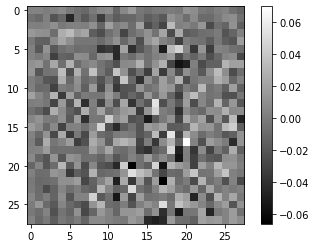

In [32]:
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.colorbar()
plt.show()

### 2-2 판별자 구현하기

판별자는 이미지를 입력받으면 해당 이미지가 진짜인지 가짜인지 판단하는 값을 출력한다.

입력은 생성자의 출력값인 28,28,1이고 출력은 하나의 숫자이다.

판별자는 생성자와 반대로 레이어를 거치면서 크기가 점점 줄어들다 (28,28,1) > (14,14,64) > (7,7,128) 세번째 `Flatten`층을 만나면서 (7,7,128) > (1, 6272)1차원 벡터로 변환된다.

마지막 Dense레이어를 거쳐 하나의 값으로 출력된다.

In [33]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [34]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

아까 위에서 생성했던 가짜 이미지를 입력하면 텐서 형태로 출력된다.

In [36]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00169283]], dtype=float32)>

### 2-3 손실함수

GAN은 손실함수로 교차 엔트로피를 사용한다. 판별자는 한 개의 이미지를 가짜와 진짜로 구분하기 때문에 binary cross entropy를 사용한다.

손실함수를 사용해서 정량적으로 달성해야 하는 목표. 진짜 이미지는 1, 가짜 이미지는 0이라고 했을 때 생성자는 판별자가 가짜 이미지를 판별한 값이 1에 가깝게 만들어야하고 판별자는 진짜는 1, 가짜는 0에 가깝게 판별하는 것이다.

결국 생성자든 구분자든 손실함수에 들어가는 값은 모두 **판별자의 판별값**이 된다.

교차 엔트로피를 계산하기 위해 입력하는 값은 판별값인데 판별자 모델의 마지막 레이어에는 값을 정규화하는 활성화 함수가 없다. 즉, 출력값은 범위가 정해지지 않아서 모든 실수가 될 수 있다. 

`tf.keras.losses.BinaryCrossentropy`는 기본적으로 인풋값이 0-1사이의라고 가정한다. 따라서 `from_logits=True`를 사용해서 입력값을 함수내부의 시그모이드 함수를 사용해서 정규화해준다. 

In [37]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

손실함수를 사용해서 계산할 값은 두 가지다. `1. fake_output 2. real_output` 

`fake_output`은 생성자가 생성한 가짜 이미지를 판별자가 판별한 값이다. `D(fake_image)`
`real_output`은 기존에 있는 진짜 이미지를 판별자가 판별한 값이다. `D(real_image)`

- generator_loss 

생성자의 손실은 `fake_output`이 1에 가까워져야기 때문에 `tf.ones_like`를 사용해서 `fake_output`와 형태가 같고 1로 가득찬 정답을 만들어서 두 가지를 비교하여 교차 엔트로피 값을 계산한다. 즉 두 값이 가까워질 수록 손실은 작아진다.

In [38]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

- discriminator_loss

판별자 손실은 진짜와 가짜 판별값 모두를 입력 받고 `real_output`은 1과 가까울 수록 `fake_output`은 0과 가까울 수록 손실이 작아진다. 마찬가지로 `tf.ones_like과 tf.zeros_like`을 사용해서 비교할 정답값을 만든다. 두 가지 손실을 다 계산하고 최종적으로 합친다.

In [39]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

- discriminator accuracy

판별자가 얼마나 정확하히 판별하는지 정확도를 계산하는 것은 GAN의 학습에서 매우 중요하다. 가짜와 진짜의 두 정확도를 따로 계산해서 비교하는 것이 유용하다. 

초반에는 판별자가 진짜와 가짜 모두 정확히 구별할 수 있을 것이다. 하지만 모델의 훈련이 잘 된다면 학습할 수록 판별자의 정확도는 떨어지게 된다. 생성자의 성능이 올라가고 있다는 뜻이다. 

1. `tf.math.greater_equal(real_output, tf.constant([0.5])`로 각 원소가 0.5이상은 True 아니면 False로 반환한다.

2. `tf.cast((1), tf.float32)`로 True면 1로 False면 0으로 만든다. 

3. `tf.reduce_mean((2))`으로 평균을 내서 이번 배치의 정확도를 계산한다.

In [40]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

### 2-4 최적화 함수

**Adam 최적화 기법**을 사용한다. 

중요한 하이퍼 파라미터인 `learning rate`은 0.0001로 설정하고 여러 값으로 바꿔가며 학습해볼 수 있다.

생성자와 판별자는 따로 학습을 하는 개별 네트워크기 때문에 optimizer도 따로 만들어줘야 한다.

In [41]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

매번 학습진행을 확인하기 위해 생성자가 생성한 샘플을 확인한다. 

샘플은 한 번에 16장을 생성한다. 
생성할 샘플은 매 번 같은 노이즈로 생성해야 학습과정을 확인할 수 있기때문에 고정된 seed노이즈를 만든다. 
100차원의 노이즈를 16개 (16,100) 벡터를 만들어둔다.

In [42]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

## 3. 훈련과정 설계


하나의 미니 배치 당 진행할 `train_step`함수를 생성한다. 

`@tf.function`를 함수위에 붙이면 함수 입력값을 `Tensorflow의 graph` 노드가 될 수 있는 타입으로 자동 변환된다.

1. 실제 이미지 역할을 할 `images`한 세트를 입력받는다.

2. 생성자 입력 노이즈 : 생성자가 가짜 이미지를 생성하기 위한 노이즈를 입력 이미지 한 세트와 같은 크기인 BATCH_SIZE만큼 생성한다.

3. 가중치 갱신을 위한 기울기를 자동 미분으로 계산하기 위해서.

4. 생성자가 노이즈를 입력받은 후 `generated_images`이미지 생성.

5. 판별자가 진짜와 가짜 이미지를 입력받고 `real_output, fake_output` 출력

6. 판별자의 출력으로 각각 손실 계산

7. 손실을 가지고 정확도 계산

8. 손실을 가지고 기울기 계산

9. 계산된 기울기를 가지고 optimizer에 입력해 가중치 갱신

10. 이번 스탭에서 계산된 손실과 정확도를 리턴

In [44]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

일정 간격으로 학습현황를 볼 수 있는 샘플을 생성하는 함수만들기. 

위에서 만든 고정 seed를 이용해서 결과물을 만들기 때문에 얼마나 성능이 나아지고 있는지 파악할 수 있다.

In [45]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')
   
    plt.savefig('{}/aiffel/dcgan_newimage/fashion/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

손실과 정확도 그래프 함수. 

`train_step()`함수가 반환하는 손실과 정확도를 매 에포크마다 시각화하는 함수를 생성한다. 

In [46]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/fashion/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

`tf.train.Checkpoint`를 사용하면 매번 모델을 직접 저장하지 않고도 버전 관리를 할 수 있다. 

checkpoint에는 optimizer와 생성자, 판별자를 모두 넣어서 저장한다. 정확히는 학습한 모델 가중치를 저장한다.

In [47]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/fashion/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## 4. 학습시키기

1. 한 단계 학습하는 `train_step`

2. 샘플 이미지를 생성, 저장하는 `generate_and_save_images()`

3. 학습과정을 시각화하는 `draw_train_history()`

4. 모델을 저장하는 `checkpoint`

생성한 4가지 함수를 한 곳에 모아준다.

In [48]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

`save_every` : 모델 저장하는 간격

In [49]:
save_every = 5
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 학습시작!!

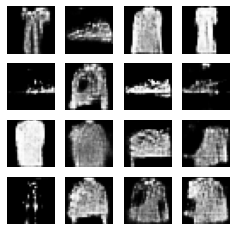

Time for training : 757 sec


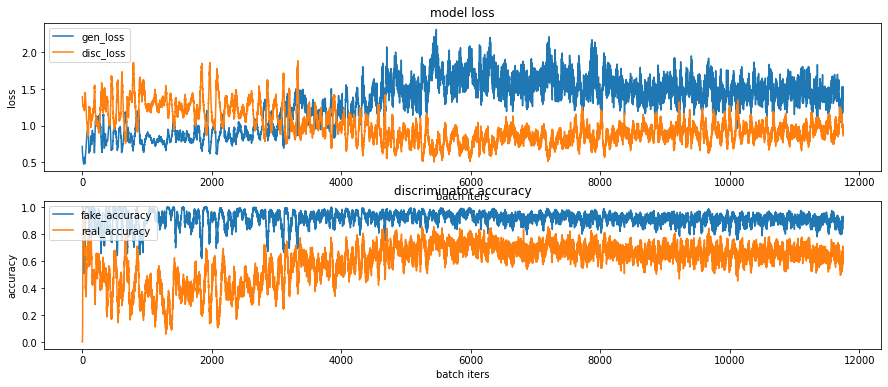

CPU times: user 6min 29s, sys: 1min 19s, total: 7min 48s
Wall time: 12min 39s


In [51]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/fashion/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

fake_accuracy가 계속 1에 가깝다면 생성자가 만든 이미지가 판별자를 속이지 못하고 있다는 뜻이다. 더 학습이 필요하다. 그래프를 살피면서 훈련이 계속돼도 변화가 없다면 다른 방법을 찾아봐야 한다.

### 학습과정 시각화하기

학습하며 생성했던 샘플 이미지들을 합쳐서 GIF파일로 만든다.

In [52]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/fashion/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif

-rw-r--r-- 1 root root 1070074 Feb  8 06:49 /aiffel/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif


와우!!!! 움짤로 보니까 엄청 신기하다

# 실습 : CIFAR-10 이미지 생성하기

## 1. 작업환경 구성

## 2. 데이터셋 구성

1. train_x를 -1~1로 정규화한다.

2. 학습 데이터를 시각화해서 확인한다. 

3. `from_tensor_slices()`로 미니배치 데이터셋 구성하기

In [78]:
# 데이터 로드
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

In [79]:
# 픽셀값 확인
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


In [80]:
# 이미지 정규화
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


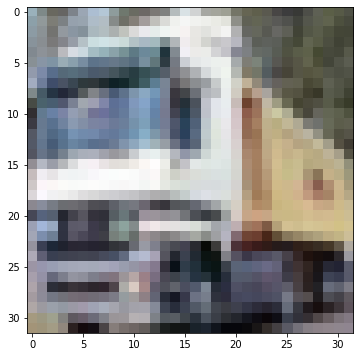

In [139]:
plt.imshow(((train_x[1]+127.5)*127.5).astype(np.uint8))

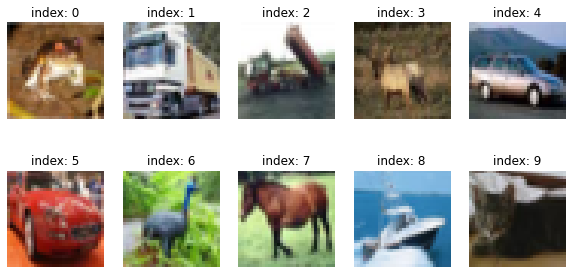

In [140]:
# 데이터 시각화
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(((train_x[i]+127.5)*127.5).astype(np.uint8))
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

In [82]:
# 미니배치 데이터셋 구성
BUFFER_SIZE = 50000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## 3. 생성자 모델 구현

- (32, 32, 3)의 shape를 가진 이미지를 생성하는 생성자 모델 구현 함수를 작성해 봅시다.

- noise = tf.random.normal([1, 100])로 생성된 랜덤 노이즈를 입력으로 하여 방금 구현한 생성자로 랜덤 이미지를 생성해 봅시다.

- 생성된 랜덤 이미지가 생성자 출력 규격에 잘 맞는지 확인해 봅시다.

In [85]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [86]:
generator = make_generator_model()

generator.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 16384)             1638400   
_________________________________________________________________
batch_normalization_6 (Batch (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 16384)             0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_7 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 8, 8, 128)        

랜덤 이미지가 생성자 출력 규격에 맞는지 확인

(1, 32, 32, 3)


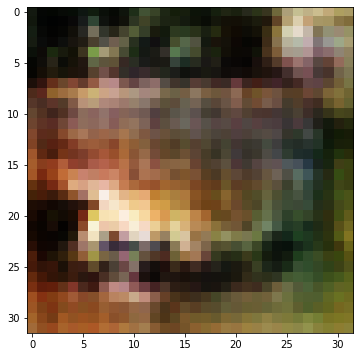

In [151]:
noise = tf.random.normal([1, 100])

generated_image = generator(noise, training=False)
print(generated_image.shape)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()

## 4. 판별자 모델 구현

- (32, 32, 3)의 이미지를 입력으로 받아 1dim을 판별결과를 출력하는 판별자 모델 구현 함수를 작성해 봅시다.

- 위 STEP 2에서 생성한 랜덤 이미지를 판별자 모델이 판별한 결과값을 확인해 봅시다.

In [90]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [91]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)             

In [92]:
# 결과값 확인
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00184326]], dtype=float32)>

## 5. 손실함수와 최적화 함수 구현

- 생성자와 판별자의 손실함수(loss)를 구현해 봅시다.

- 판별자의 출력값을 가지고 실제/생성(real/fake) 이미지 판별 정확도(accuracy)를 계산하는 함수를 구현해 봅시다.

- 생성자와 판별자를 최적화하는 optimizer를 정의합니다.

In [94]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

## 6. 훈련과정 상세 기능 구현

- 1개 미니배치의 훈련 과정을 처리하는 train_step() 함수를 구현해 봅시다.

- 16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화하는 generate_and_save_images() 함수를 구현해 봅시다.

- 훈련 epoch마다 생성자/판별자의 loss 및 판별자의 실제/생성(real/fake) 이미지 판별 accuracy 히스토리(history)를 그래프로 시각화하는 draw_train_history() 함수를 구현해 봅시다.

- training_checkpoints 디렉토리에 몇 epoch마다 모델을 저장하는 checkpoint 모듈을 설정해 봅시다.

In [103]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0])
        plt.axis('off')
   
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()
    
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()    

In [106]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## 7. 학습 과정 진행

- 위 STEP 5에서 구현한 기능들을 활용하여 최소 50 epoch만큼의 모델 학습을 진행해 봅시다.

- 학습 과정에서 생성된 샘플 이미지로 만든 gif 파일을 통해 학습 진행 과정을 시각적으로 표현해 봅시다.

- 학습 과정을 담은 샘플 이미지, gif 파일, 학습 진행 그래프 이미지를 함께 제출합니다.

(참고) 학습 과정 중 학습 epoch를 추가 진행해야 하거나, 학습한 모델을 활용하여 이미지를 생성할 필요가 생깁니다. 그럴 때마다 모델 학습을 처음부터 다시 진행한다면 시간 낭비가 될 것입니다.
우리는 위에서 checkpoint 모듈을 이용해 모델을 저장해 둔 바 있습니다. 이를 이용해 학습해 둔 모델을 로드하면 모델 재학습이 필요 없이 이런 작업을 진행할 수 있습니다.
아래는 checkpoint 모듈을 활용하여 모델을 로드하는 예시입니다.

In [107]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [160]:
save_every = 5
EPOCHS = 500

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 훈련

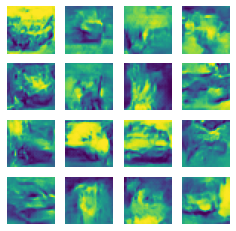

Time for training : 8341 sec


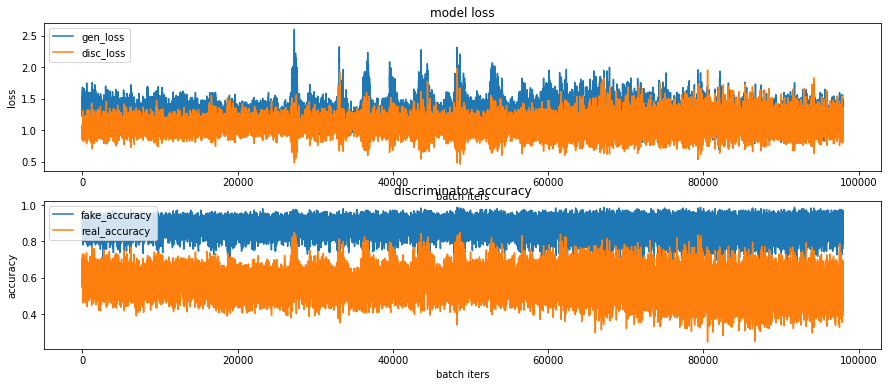

CPU times: user 2h 22min 29s, sys: 13min 9s, total: 2h 35min 38s
Wall time: 2h 19min 7s


In [162]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/fashion/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

In [163]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/fashion_mnist_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/fashion_mnist_dcgan.gif

-rw-r--r-- 1 root root 4092156 Feb  8 12:52 /aiffel/aiffel/dcgan_newimage/cifar10/fashion_mnist_dcgan.gif


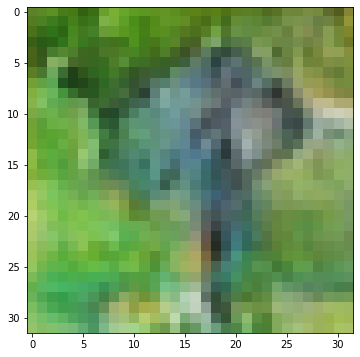

In [165]:
# 체크포인트 불러오기
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

## 회고

에포크 500으로 훈련을 돌리니 흐릿하게나마 형태가 있는 이미지가 생성되었다. 